In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import imageio

# plt.style.use(['dark_background', 'bmh'])
plt.style.use(['seaborn-v0_8-whitegrid', 'bmh'])
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 12}
plt.rc('font', **font)
plt.rc('axes', facecolor='w')
plt.rc('figure', facecolor='w')
plt.rc('figure', figsize= (6, 3), dpi=150)

In [6]:
def plot_sctter3D(df, key, type = 'FBG'):
    x_plot, y_plot = df['x'], df['y']

    i_case = df.columns.get_loc(key)
    tmp = df.iloc[:, i_case]
            
    fig = plt.figure(figsize = (7, 2), facecolor='w', dpi = 150)
    ax = plt.axes(projection ='3d', facecolor='w')
    for y_ind in y_plot.unique():
        ind_ = (y_plot == y_ind)
        markerline, stemlines, baseline = ax.stem(x_plot[ind_], y_plot[ind_], tmp[ind_],
                                                markerfmt = '.')
        plt.setp(stemlines, 'alpha', 0.4)
        ax.scatter(x_plot[ind_], y_plot[ind_], tmp[ind_], edgecolors = 'k', s = 3)
        
    for x_ind in x_plot.unique():
        ind_ = (x_plot == x_ind)
        markerline, stemlines, baseline = ax.stem(x_plot[ind_], y_plot[ind_], tmp[ind_],
                                                markerfmt = '.')
        plt.setp(stemlines, 'alpha', 0.4)
        ax.scatter(x_plot[ind_], y_plot[ind_], tmp[ind_], edgecolors = 'k', s = 3)

    ax.set_title(f'strain of {type} [{key}] (unit: $\mu m$ & mm)', fontsize = 10)
    ax.set_xlabel(f'x (mm)', fontsize = 8)
    ax.set_ylabel(f'y (mm)', fontsize = 8)
    ax.set_ylim(1000, 9000)
    ax.tick_params(axis='x', labelsize=6, rotation = -70)
    ax.tick_params(axis='y', labelsize=6)
    ax.xaxis.labelpad = 5
    ax.yaxis.labelpad = 5
    ax.set_yticks(y_plot.unique())
    ax.view_init(elev=55., azim=-110)

    
    
def check_each_rawdata_by_image(data, key):
    import os
    dir_sv_fig = './img'
    os.makedirs(dir_sv_fig, exist_ok = True)

    def create_frame(t):
        plt.plot(data.iloc[:, t])
        plt.title(f'{key} #{t}', fontsize=14)
        plt.savefig(f'./img/img_{t}.png', 
                    transparent = False,  
                    facecolor = 'w')
        plt.close()

    for t in range(len(data.columns)):
        create_frame(t)

    frames = []
    for t in range(len(data.columns)):
        image = imageio.v2.imread(f'./img/img_{t}.png')
        frames.append(image)

    imageio.mimsave(f'./{key}.gif', # output gif
                    frames,          # array of input frames
                    fps = 1)         # optional: frames per second

## **1. BOCDA**
#### **1.1 Import raw data**

In [7]:
# Index of CFRP Bar for BOCDA
bit_x = np.array([
    [100, 600 + 1],
    [850, 1350 + 1],
]) - 1

# bit_x = np.array([
#     [114, 620 + 1],
#     [883, 1389 + 1],
# ]) - 1

# bit_x = np.array([
#     [154, 580 + 1],
#     [923, 1349 + 1],
# ]) - 1 # 4325

x_loc, y_loc = {}, {}
x_loc['LF'] = np.arange(0, (bit_x[0, 1] - bit_x[0, 0])*50 + 0, 50)
y_loc['LF'] = np.array([1900, 1900*3])

print(f"- # points: {x_loc['LF'].shape[0]}")

print(f"- length: {x_loc['LF'][-1] - x_loc['LF'][0]} mm")
bit_x[:, 1] - bit_x[:, 0]

- # points: 501
- length: 25000 mm


array([501, 501])

In [8]:
# Merge all files in each loading cases
import glob
# lc_cases = [0, 1, 2, 3, 5, 7]
lc_cases = [0, 1, 2, 5, 7]
df_list = {}
for i0 in lc_cases:
    fn = f'./rawdata/LC0{i0}_*.txt'
    print(fn)
    txtfiles = []
    for file in glob.glob(fn):
        txtfiles.append(file.replace('\\', '/'))


    for idx, txtfile in enumerate(txtfiles):
        data_tmp = pd.read_csv(txtfile, sep = '\t')
        data_tmp.drop(['Bit'], axis = 1, inplace = True)
        if idx == 0:
            data = data_tmp.values.reshape(-1, 1)
        else:
            data = np.concatenate((data, data_tmp.values.reshape(-1, 1)), axis = 1)
            
    df = pd.DataFrame(data)
    df.index = [i for i in range(df.shape[0])]
    df_list[f'LC0{i0}'] = df

# df_list

./rawdata/LC00_*.txt
./rawdata/LC01_*.txt
./rawdata/LC02_*.txt
./rawdata/LC05_*.txt
./rawdata/LC07_*.txt


(1522, 17)


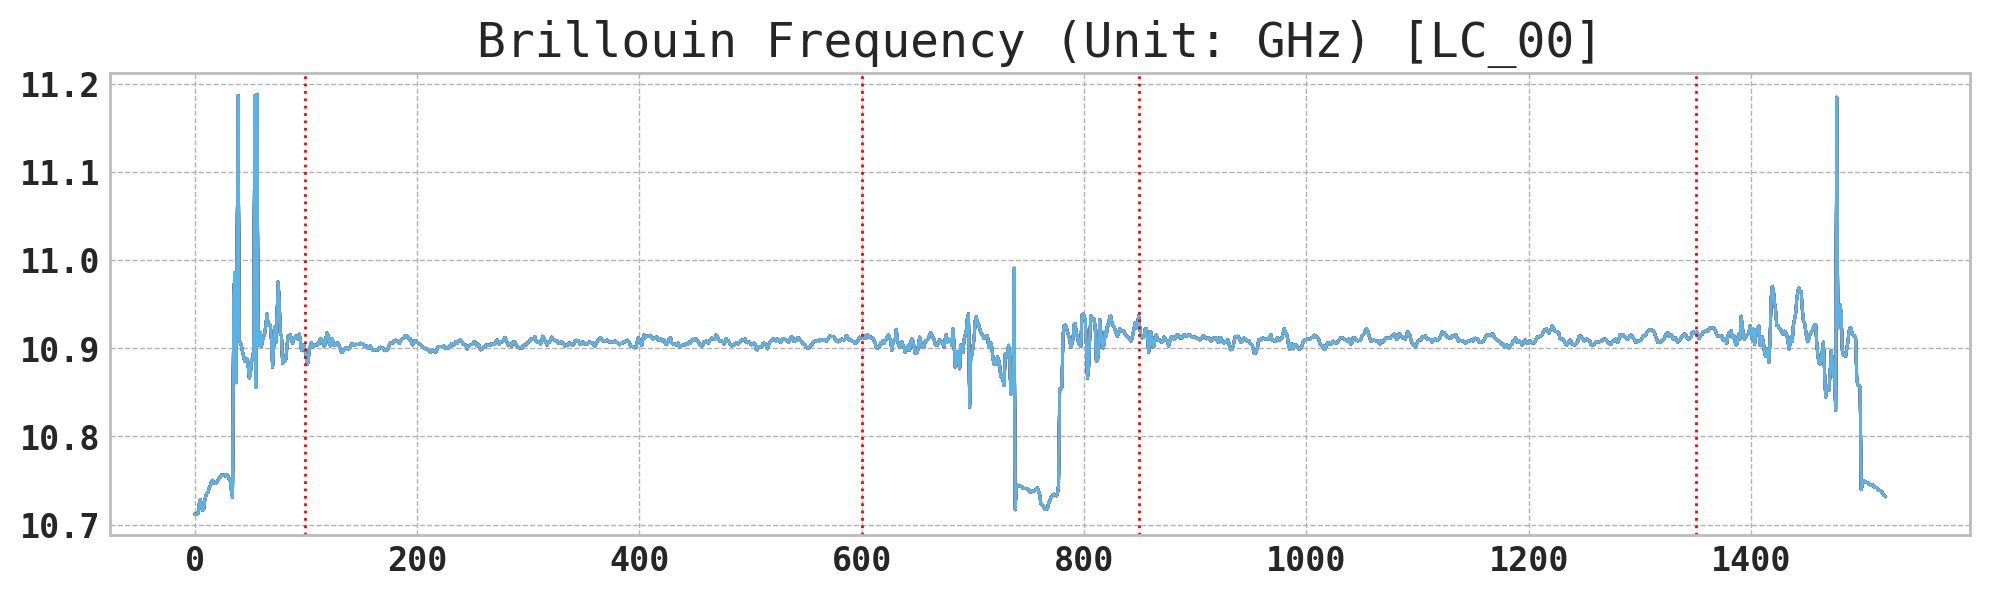

(1522, 3)


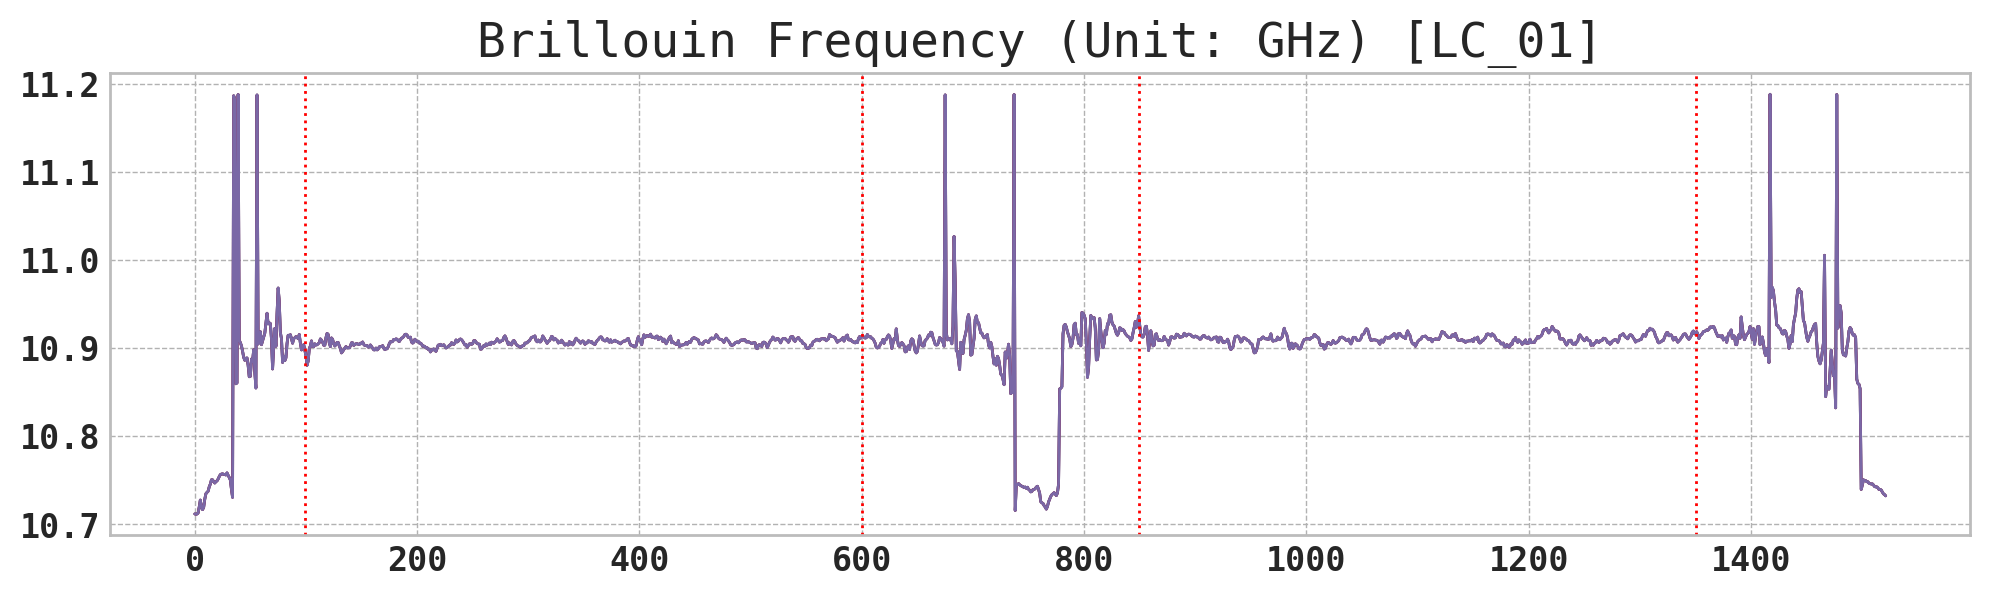

(1522, 3)


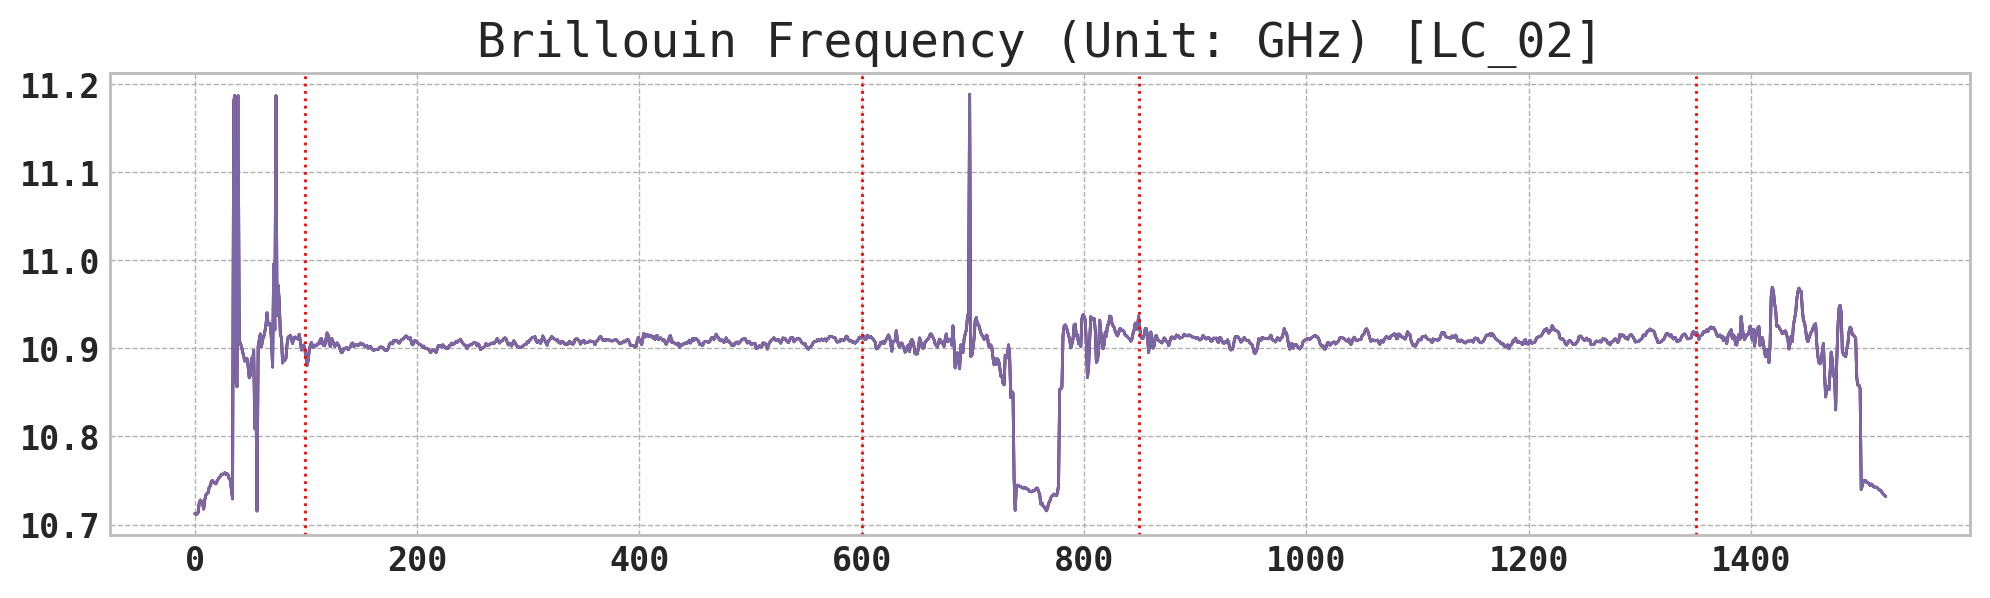

(1522, 5)


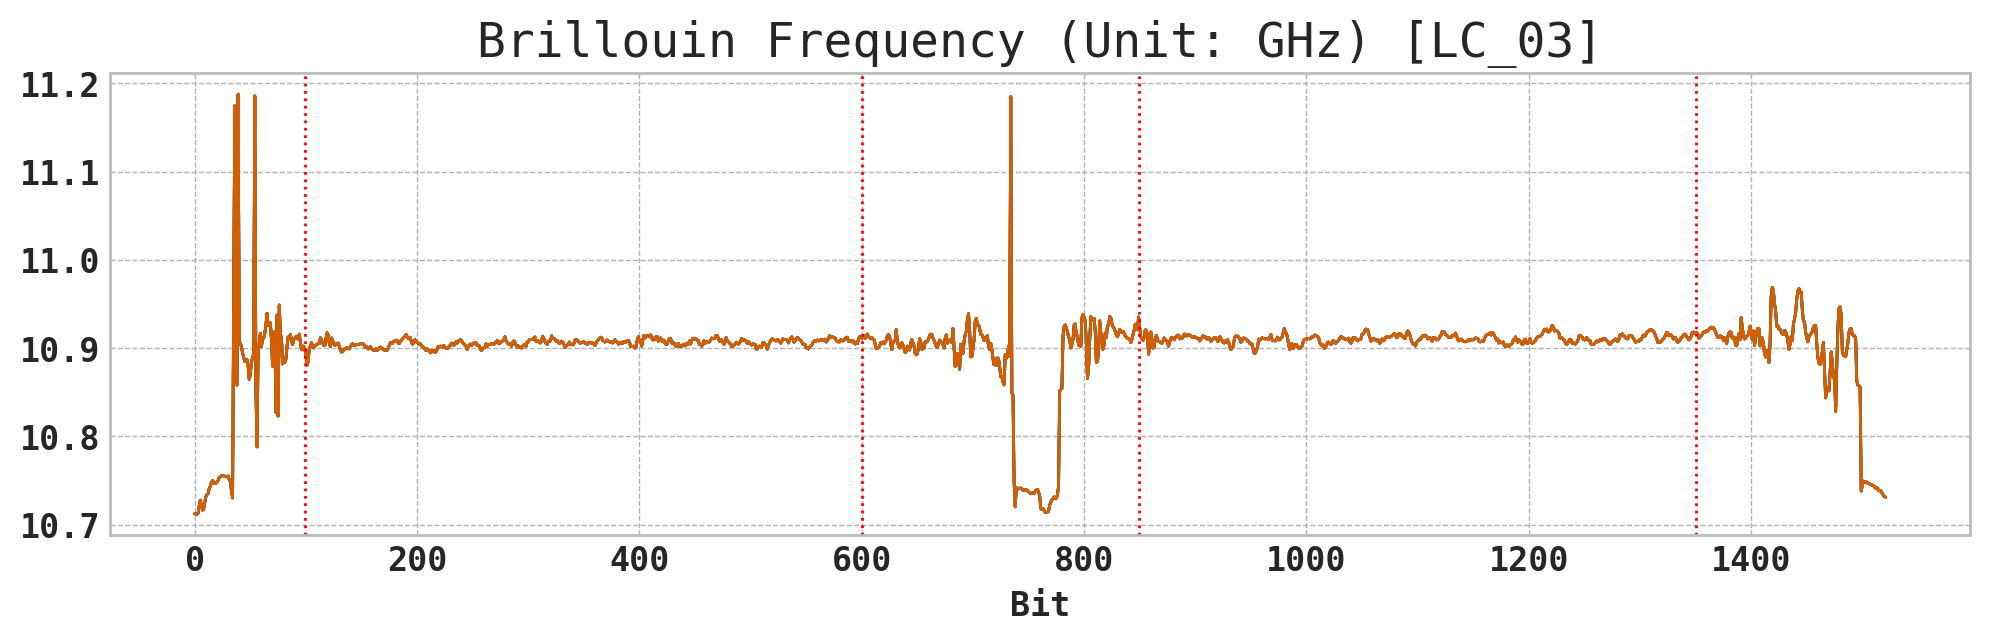

(1522, 3)


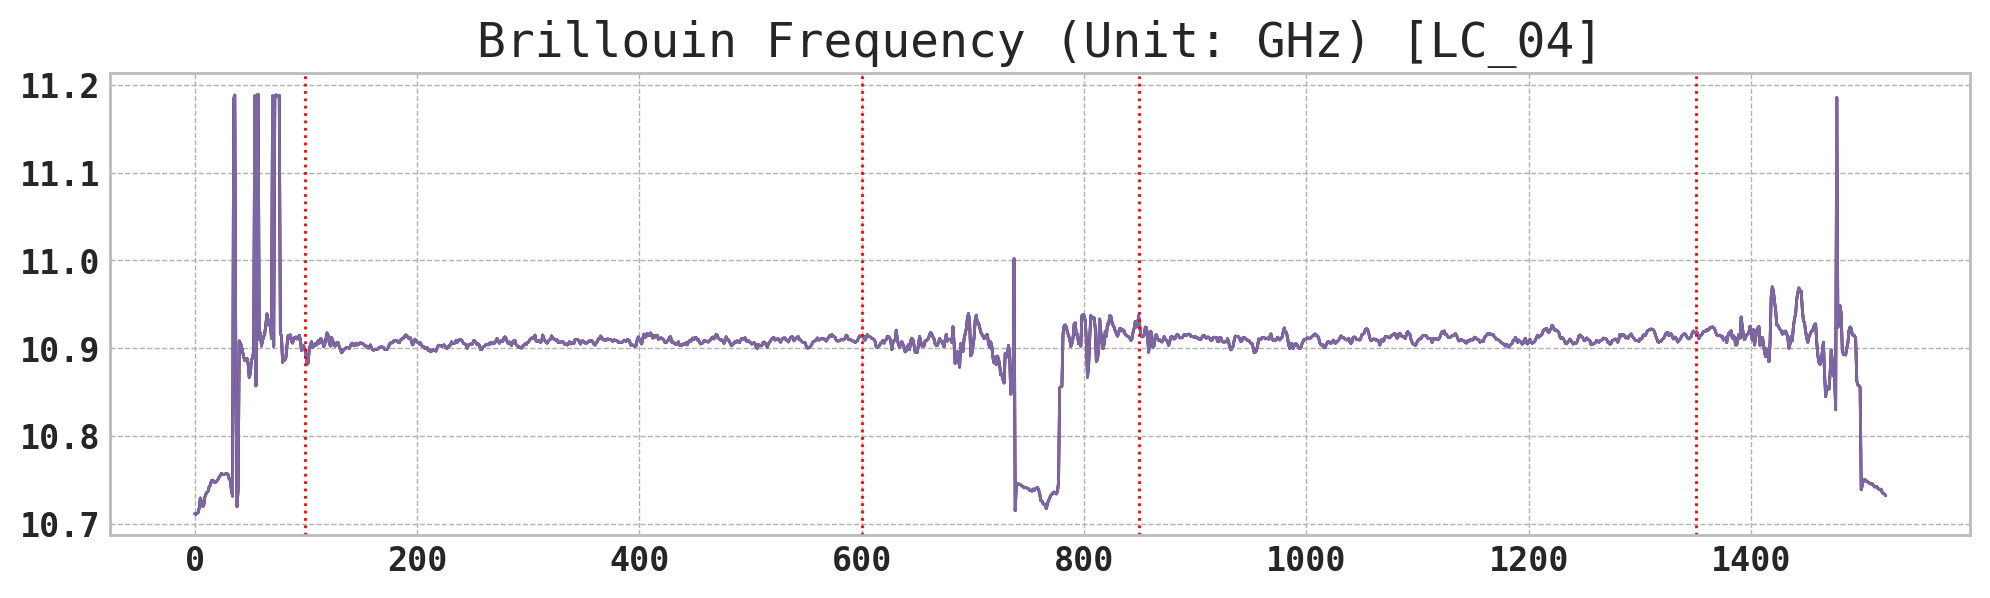

In [9]:
# Plot medians for each measurements
i0 = 0

for key, values in df_list.items():
    x0 = df_list[key].index.to_numpy().reshape(-1, 1)
    y = df_list[key].values
    print(y.shape)
    if i0 == 0:
        y_med = np.median(y, axis = 1).reshape(-1, 1)
    else:
        y_med = np.concatenate((y_med, np.median(y, axis = 1).reshape(-1, 1)), axis = 1)

    if 1:
        fig, ax = plt.subplots(1, 1, figsize = (12, 3), dpi = 200)
        for i in range(y.shape[1]):
            ax.plot(y_med[:, i0], linewidth = 1)
        
        ymin, ymax = ax.get_ylim()[0], ax.get_ylim()[1]
        for bit_x_ in bit_x:
            ax.vlines(bit_x_[0], ymin = ymin, ymax = ymax, linestyles = ':', color = 'r', linewidth = 1)
            ax.vlines(bit_x_[1], ymin = ymin, ymax = ymax, linestyles = ':', color = 'r', linewidth = 1)
            
        ax.set_ylim(ymin, ymax)
        ax.set_title(f'Brillouin Frequency (Unit: GHz) [LC_0{i0}]')
        if i0 == 3:
            ax.set_xlabel('Bit')
        plt.show()

    else:
        fig, ax = plt.subplots(1, 2, figsize = (12, 3), dpi = 200)
        for i in range(y.shape[1]):
            ax[0].plot(y[:, i], linewidth = 1)
            ax[1].plot(y_med[:, i0], linewidth = 1)
        
        ymin, ymax = ax[0].get_ylim()[0], ax[0].get_ylim()[1]
        for bit_x_ in bit_x:
            ax[0].vlines(bit_x_[0], ymin = ymin, ymax = ymax, linestyles = ':', color = 'r', linewidth = 1)
            ax[0].vlines(bit_x_[1], ymin = ymin, ymax = ymax, linestyles = ':', color = 'r', linewidth = 1)

            ax[1].vlines(bit_x_[0], ymin = ymin, ymax = ymax, linestyles = ':', color = 'r', linewidth = 1)
            ax[1].vlines(bit_x_[1], ymin = ymin, ymax = ymax, linestyles = ':', color = 'r', linewidth = 1)
        
        ax[0].set_ylim(ymin, ymax)
        ax[1].set_ylim(ymin, ymax)    
        ax[0].set_title(f'Raw data [LC_0{i0}]')
        ax[1].set_title(f'Brillouin Frequency (Unit: GHz) [LC_0{i0}]')
        plt.show()
        
    i0 += 1


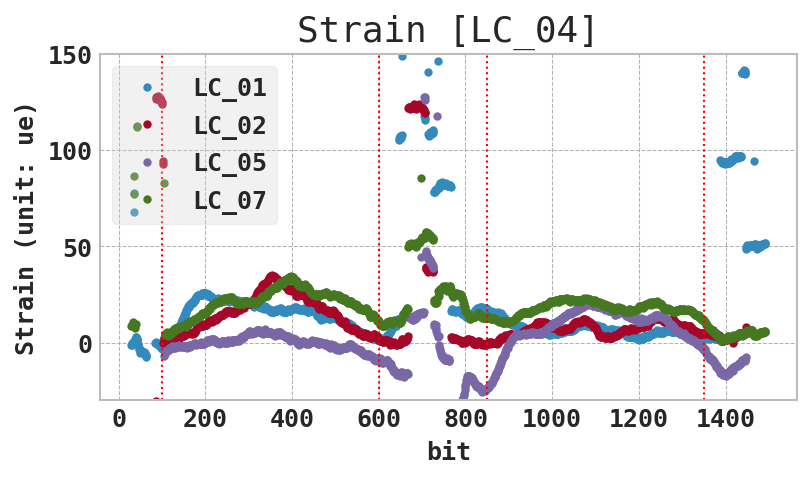

In [10]:
run_mvavg, n_win = 1, 30

df = pd.DataFrame(y_med)
df.index = x0.reshape(-1, )
df.columns = [f'LC_0{i}' for i in range(y_med.shape[1])]

if run_mvavg:
    df_mvavgf = df.rolling(window = n_win).mean() # Do moving average
    df_mvavgb = df.iloc[::-1, :].rolling(window = n_win).mean() # Do moving average
    df_mvavg = (df_mvavgf + df_mvavgb)/2

df_strain = pd.DataFrame()
for ind in range(1, df.shape[1]):
    if run_mvavg:
        strain_ = (df_mvavg.iloc[:, ind] - df_mvavg.iloc[:, 0]) * 2e4 # BOCDA => strain 
    else:
        strain_ = (df.iloc[:, ind] - df.iloc[:, 0]) * 2e4 # BOCDA => strain 
        
    df_strain = pd.concat([df_strain, strain_], axis = 1)
    df_strain.dropna(inplace = True)
    
    if 1:
        plt.plot(df_strain.index, df_strain.iloc[:, -1], '.', label = f'LC_0{lc_cases[ind]}')
        plt.xlabel('bit')
        plt.ylabel('Strain (unit: ue)')
        plt.title(f'Strain [LC_0{ind}]')
        plt.ylim(-30, 150)
    
ymin, ymax = plt.gca().get_ylim()
for bit_x_ in bit_x:
    plt.vlines(bit_x_[0], ymin = ymin, ymax = ymax, linestyles = ':', color = 'r', linewidth = 1)
    plt.vlines(bit_x_[1], ymin = ymin, ymax = ymax, linestyles = ':', color = 'r', linewidth = 1)
plt.legend(frameon = True, facecolor = 'lightgrey', framealpha=0.3)
plt.show()

#### **2.2 Compute Strains**

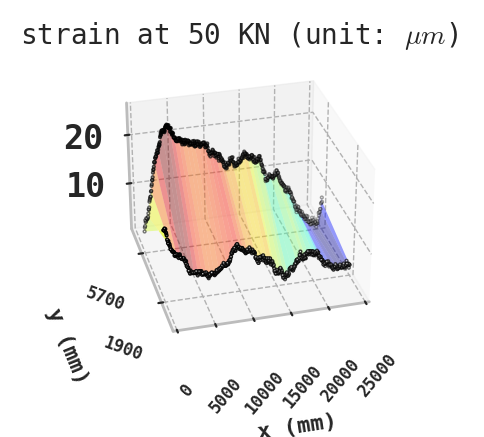

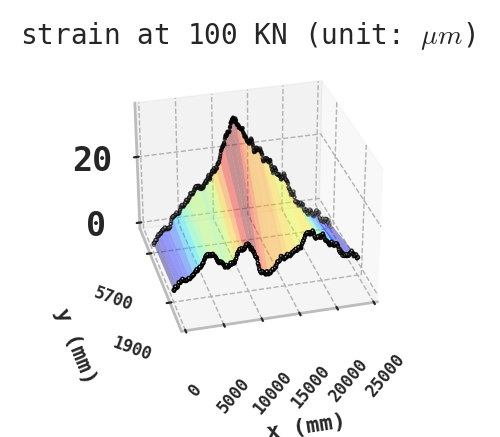

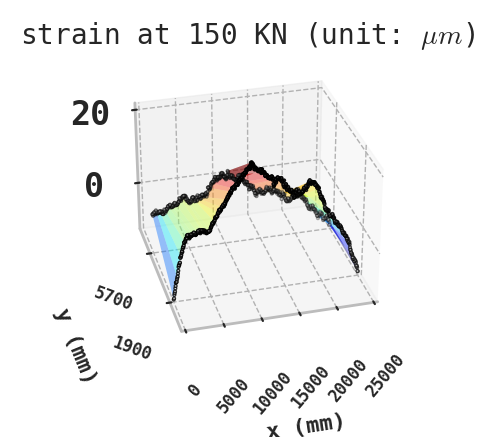

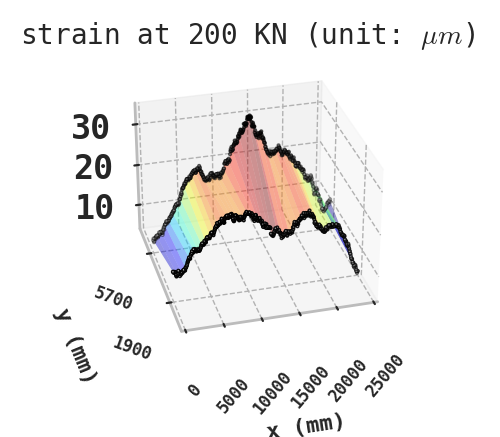

,LC01,LC02,LC03,LC04,x,y
0,4.869000,1.011667,-2.236000,7.078333,0.0,5700.0
1,5.697667,0.527667,-2.144000,7.506667,50.0,5700.0
2,5.991333,1.098667,-2.635667,6.570333,100.0,5700.0
3,7.192667,1.290000,-2.069000,6.804000,150.0,5700.0
4,6.781000,1.178333,-1.837333,7.368667,200.0,5700.0
...,...,...,...,...,...,...
997,2.668333,3.368000,-10.650667,4.928667,24800.0,1900.0
998,2.787333,3.204000,-10.375333,4.894667,24850.0,1900.0
999,1.922000,3.410667,-10.885667,4.484333,24900.0,1900.0
1000,2.545333,3.622333,-11.868667,4.975000,24950.0,1900.0


In [12]:
df_strain.columns = [f'LC_0{lc_cases[i]}' for i in range(1, y_med.shape[1])]
x_plot, y_plot = np.meshgrid(x_loc['LF'], y_loc['LF'][::-1])

for i_case in range(df_strain.shape[1]):
    for ind in range(bit_x.shape[0]):
        if ind == 0:
            tmp_array = df_strain.iloc[bit_x[ind, 0]:bit_x[ind, 1], i_case].values.reshape(-1, 1)
            tmp  = df_strain.iloc[bit_x[ind, 0]:bit_x[ind, 1], i_case].values.reshape(-1, 1)
            x = x_loc['LF'].reshape(-1, 1)
            y = y_loc['LF'][-1 - ind] * np.ones_like(x)
            
        else:
            if ind % 2 == 0:
                tmp_ = df_strain.iloc[bit_x[ind, 0]:bit_x[ind, 1], i_case].values[::-1].reshape(-1, 1)
                x_ = x_loc['LF'][::-1].reshape(-1, 1)
                y_ = y_loc['LF'][-1 - ind] * np.ones_like(x_)
            else:
                tmp_ = df_strain.iloc[bit_x[ind, 0]:bit_x[ind, 1], i_case].values.reshape(-1, 1)
                x_ = x_loc['LF'].reshape(-1, 1)
                y_ = y_loc['LF'][-1 - ind] * np.ones_like(x_)
            
            tmp_array = np.concatenate([tmp_array, tmp_], axis = 1)
            tmp = np.concatenate([tmp, tmp_], axis = 0)
            x = np.concatenate([x, x_], axis = 0)
            y = np.concatenate([y, y_], axis = 0)

    pd.DataFrame(tmp.T).to_csv(f'./rawdata/strain_BOCDA_LC_0{lc_cases[ind]}.csv') # for plotting
    if 1:
        fig = plt.figure(figsize = (7, 2), facecolor='w', dpi = 200)
        ax1 = fig.add_subplot(111, projection ='3d', facecolor='w')
        ax1.plot_surface(x_plot, y_plot, tmp_array.T, alpha=0.4, cmap=cm.jet)
        ax1.scatter(x_plot, y_plot, tmp_array.T, c = tmp_array.T, edgecolors = 'k', s = 1)
        ax1.set_title(f'strain at {(i_case + 1)*50} KN (unit: $\mu m$) ', pad = -50, fontsize = 10)
        ax1.set_xlabel(f'x (mm)', fontsize = 8)
        ax1.set_ylabel(f'y (mm)', fontsize = 8)
        ax1.set_xlim(0, 25000)
        ax1.set_ylim(0, 7600)
        ax1.set_zlim((tmp_array.min(), tmp_array.max()))
        ax1.tick_params(axis='x', labelsize=6, rotation = 50)
        ax1.tick_params(axis='y', labelsize=6, rotation = -20)
        ax1.xaxis.labelpad = 5
        ax1.yaxis.labelpad = 5
        ax1.set_yticks(y_loc['LF'])
        ax1.view_init(90, -90) # 2D
        ax1.view_init(30, -105)
        plt.show()
    
    if i_case == 0:
        tmp_mat = tmp
    else:
        tmp_mat = np.concatenate([tmp_mat, tmp], axis = 1)


strain = {}
strain['LF0'] = pd.DataFrame(np.concatenate([tmp_mat, x, y], axis = 1))
strain['LF0'].columns = [f"LC0{i+1}" for i in range(tmp_mat.shape[1])] + ['x', 'y']
strain['LF0'].to_csv('Yongsu_strain_LF0.csv', index = False)
strain['LF0']

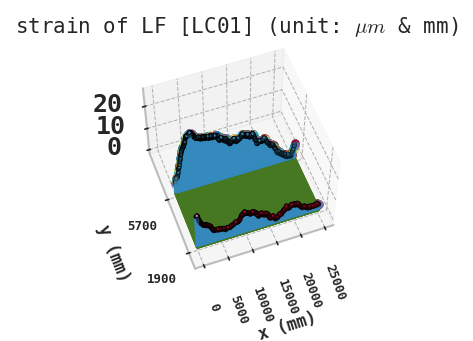

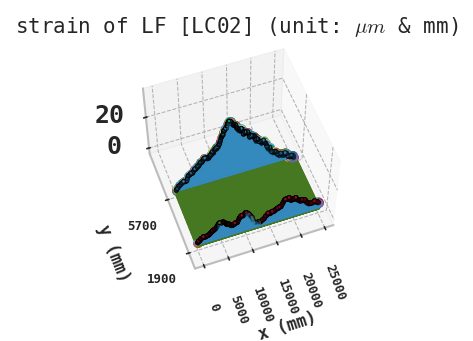

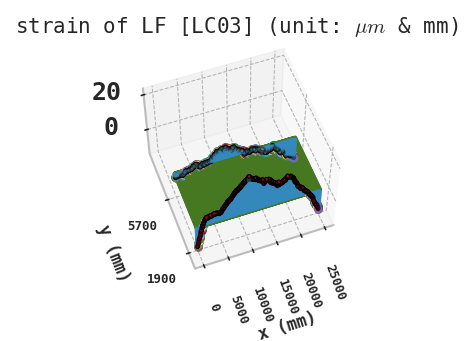

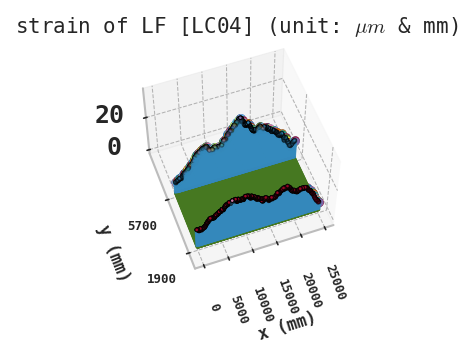

In [13]:
# plot strains in each loading cases
for i in range(strain['LF0'].shape[1] - 2):
    plot_sctter3D(strain['LF0'], f"LC0{i+1}", 'LF')

## **2. FBG**

In [16]:
FBG_ok = [i for i in range(6, 36) if i not in [18, 19, 20, 33, 34, 35]]
x_loc['HF'] = np.arange(0, len(FBG_ok)/2 * 1800, 1800)
y_loc['HF'] = np.array([1900, 1900*3])

# Import raw data and compute strain
fn_lists = [f'FBG_LC{i}.txt' for i in lc_cases[1:]]
# fn_lists = [[f'FBG_LC{i}.txt' for i in lc_cases[1:]][0]]
data = None
for fn in fn_lists:
    df = pd.read_csv('./rawdata/' + fn, sep = '\t', header=None)
    df = df.iloc[:, FBG_ok]

    if fn[6] == '1':
        fbg_ind = np.array([
            [[25, 125], [210, 310]],
            [[500, 600], [770, 870]],
            [[1100, 1200], [1320, 1420]],
            ])

    elif fn[6] == '2':
        fbg_ind = np.array([
            [[25, 125], [180, 280]],
            [[500, 600], [725, 825]],
            [[1050, 1150], [1250, 1350]],
            ])
        
    elif fn[6] == '3':
        fbg_ind = np.array([
            [[20, 120], [250, 350]],
            [[650, 750], [900, 1000]],
            [[1200, 1300], [1425, 1525]],
            ])
        
    elif fn[6] == '5':
        fbg_ind = np.array([
            [[20, 120], [200, 300]],
            [[550, 650], [725, 825]],
            [[910, 1010], [1220, 1320]],
            [[1450, 1550], [1680, 1780]],
            [[1900, 2000], [2070, 2170]],
            ])

    else:
        fbg_ind = np.array([
            [[100, 200], [400, 500]],
            [[800, 900], [1150, 1250]],
            [[1500, 1600], [1750, 1850]],
            ])

    # compute strain
    for ind, index in enumerate(fbg_ind):
        ref = np.median(df.iloc[index[0][0]:index[0][1], :], axis = 0)
        target = np.median(df.iloc[index[1][0]:index[1][1], :], axis = 0)
        if ind == 0:
            mu = (-1/0.78*(1 - target/ref)).reshape(-1, 1)* 1e6
        else:
            mu = np.concatenate(
                [mu, (-1/0.78*(1 - target/ref)).reshape(-1, 1)* 1e6],
                axis = 1)
    
    if data is None:
        data = mu.mean(axis = 1).reshape(-1, 1)
    else:
        data = np.concatenate([data, mu.mean(axis = 1).reshape(-1, 1)], axis =1)

# save strains from FBG
strain['HF'] = pd.DataFrame(data)
strain['HF']['x'] = np.concatenate([x_loc['HF'].reshape(-1, 1), x_loc['HF'].reshape(-1, 1)], axis = 0)
strain['HF']['y'] = np.concatenate([
    np.ones_like(x_loc['HF'].reshape(-1, 1)) * y_loc['HF'][1],
    np.ones_like(x_loc['HF'].reshape(-1, 1)) * y_loc['HF'][0],
    ], axis = 0)
strain['HF'].columns = [f"LC0{i+1}" for i in range(data.shape[1])] + ['x', 'y']
strain['HF'].to_csv('Yongsu_strain_HF.csv', index = False)
strain['HF']

,LC01,LC02,LC03,LC04,x,y
0,10.262937,4.694480,3.630255,4.270129,0.0,5700.0
1,15.589250,8.127203,6.242445,6.777314,1800.0,5700.0
2,19.138737,11.504743,4.762156,9.022871,3600.0,5700.0
3,21.281008,18.938110,6.043737,13.609475,5400.0,5700.0
4,17.983927,21.556314,9.302634,16.849505,7200.0,5700.0
5,13.496581,24.601839,8.388261,17.165122,9000.0,5700.0
6,12.254695,27.898952,8.045641,19.543546,10800.0,5700.0
7,12.440991,30.171462,9.669378,19.865756,12600.0,5700.0
8,8.589724,20.938999,8.784709,15.700797,14400.0,5700.0
9,7.745683,16.970652,6.095037,12.022438,16200.0,5700.0


#### **2.3 Compute Strains**

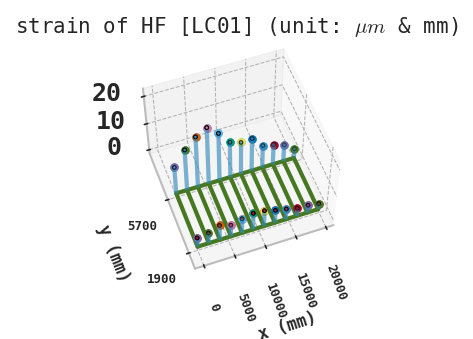

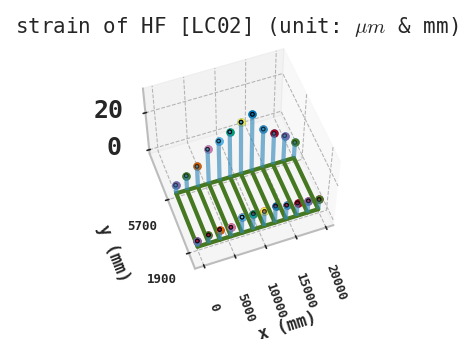

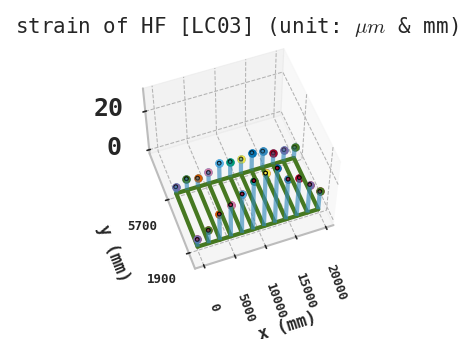

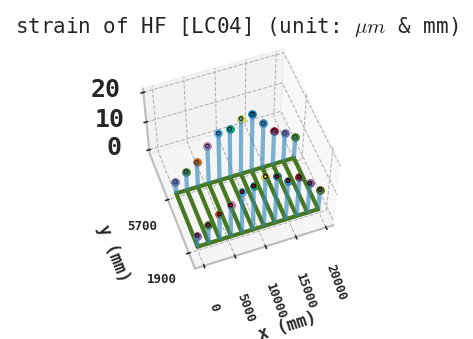

In [17]:
# plot strains in each loading cases
for i in range(strain['HF'].shape[1] - 2):
    plot_sctter3D(strain['HF'], f"LC0{i+1}", 'HF')

## **3. Displacement**
#### **3.1 Import raw data**

#### **3.2 Compute Strains**

In [18]:
# Find the best regions where matches well to FBG
def match_LF_and_HF_starting_point(strain, y_target, LF_SR):
    from scipy import spatial

    r2 = False

    df_LF = strain['LF0'].loc[round(strain['LF0']['y'], 2) == round(y_target, 2)]
    df_HF = strain['HF'].loc[round(strain['HF']['y'], 2) == round(y_target, 2)]

    interval_ind_HF =(df_HF['x'].unique()/LF_SR).astype(int)
    print(interval_ind_HF.shape)
    print(interval_ind_HF)
    i_shift, R2_all = 0, []
    stop_flag = 1

    while stop_flag:
        R2_tmp = []
        for ind_case in range(df_LF.shape[1]-2):
            HF_eval = df_HF.iloc[:, ind_case]
            LF_eval = df_LF.iloc[interval_ind_HF + i_shift, ind_case]
            
            if r2:
                R2_tmp.append(np.corrcoef(HF_eval, LF_eval)[0][1])
            else:
                R2_tmp.append(1 - spatial.distance.cosine(HF_eval, LF_eval))

        R2_all.append(R2_tmp)
        i_shift = i_shift + 1
        if (df_LF.shape[0] - interval_ind_HF[-1] - i_shift) == 0:
            stop_flag = 0

    R2_ = np.array(R2_all)
    R2 = (R2_ - R2_.min(axis = 0))/(R2_.max(axis = 0) - R2_.min(axis = 0))

    idx_best = []
    idx_best.append(y_target)
    idx_best.append(R2_.prod(axis = 1).argmax())
    idx_best.append(idx_best[1] + interval_ind_HF[-1]+1)
    
    fig, axs = plt.subplots(R2.shape[1], 1, figsize = (2 * R2.shape[1], 5), dpi = 150, sharex = True)
    for i in range(R2.shape[1]):
        axs[i].plot(R2[:, i])
        axs[i].plot(idx_best[1], R2[idx_best[1], i], 'ro')

    plt.suptitle(f'best lag = {idx_best[1]} (y = {y_target})')
    plt.show()

    return idx_best, R2_

(12,)
[  0  36  72 108 144 180 216 252 288 324 360 396]


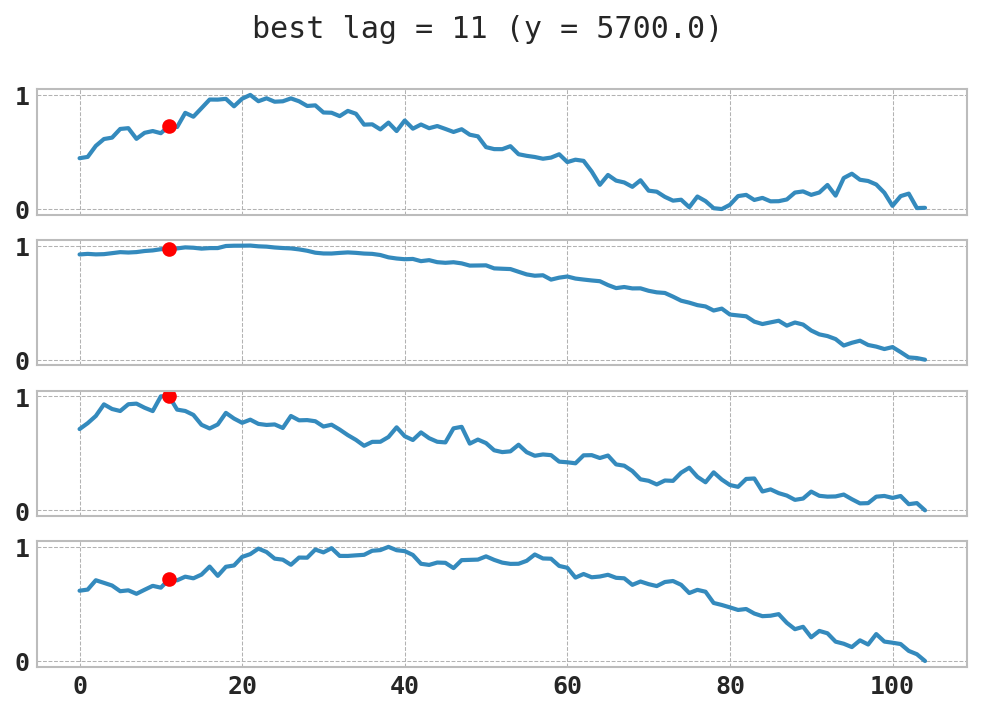

(12,)
[  0  36  72 108 144 180 216 252 288 324 360 396]


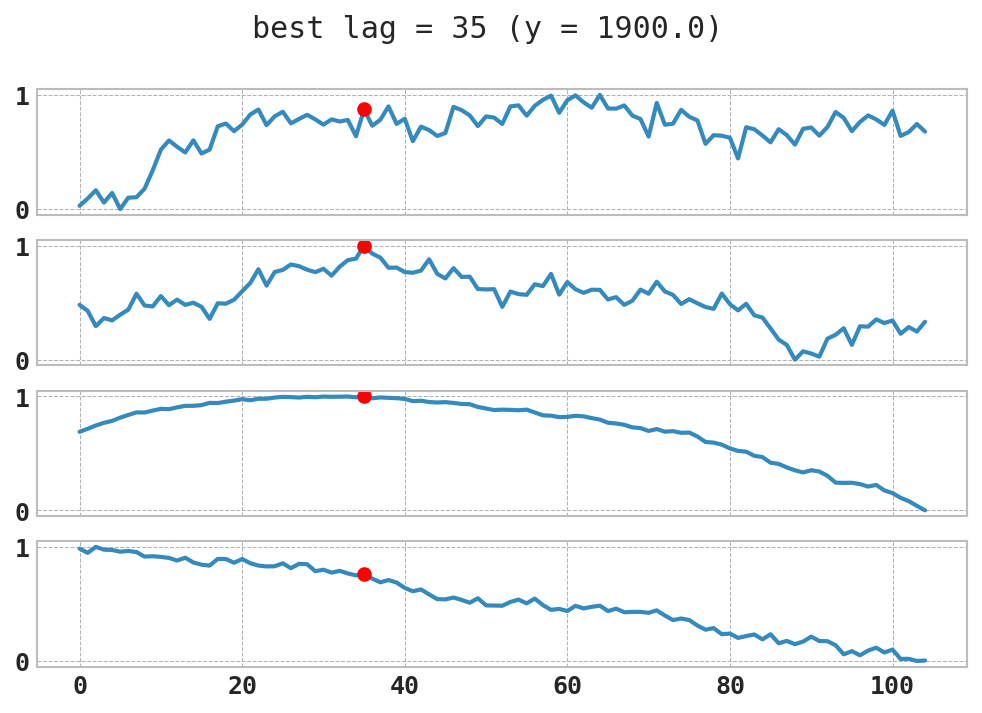

In [19]:
BOCDA_SR = 50

idx_bests, r2_all = [], []
for y_target in strain['HF']['y'].unique():
    idx_tmp, R2_tmp = match_LF_and_HF_starting_point(strain, y_target, BOCDA_SR)
    idx_bests.append(idx_tmp)
    r2_all.append(R2_tmp)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_22012\1790377996.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['x'] = np.arange(0, (tmp.shape[0])*50, 50)


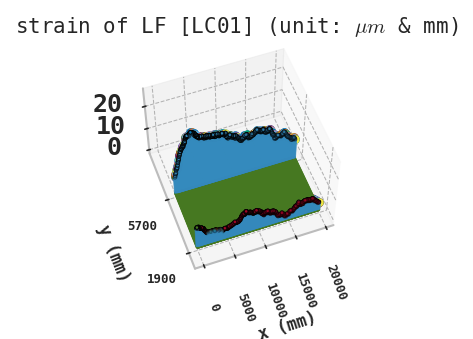

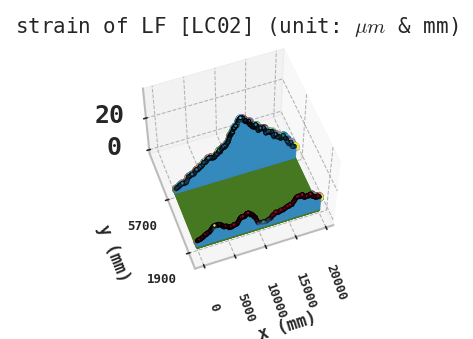

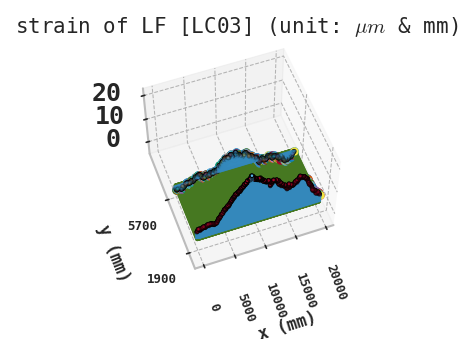

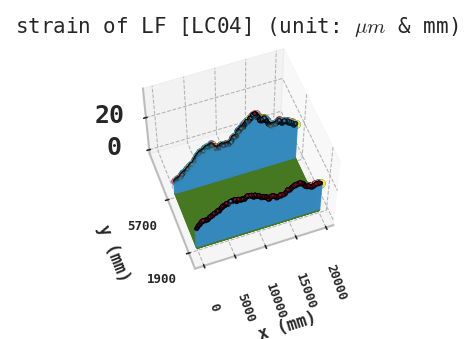

In [20]:
# Extract the matched regions
for indx, ind_best in enumerate(idx_bests):
    df = strain['LF0'].loc[round(strain['LF0']['y'], 2) == round(ind_best[0], 2)]
    tmp = df.iloc[ind_best[1]:ind_best[2], :]
    tmp['x'] = np.arange(0, (tmp.shape[0])*50, 50)

    if indx == 0:
        df_extracted = tmp.values
    else:
        df_extracted_ = tmp.values
        df_extracted = np.concatenate([df_extracted, df_extracted_], axis = 0)

df = pd.DataFrame(df_extracted)
df.columns = strain['LF0'].columns

# plot strains in each loading cases
for i in range(df.shape[1] - 2):
    plot_sctter3D(df, f"LC0{i+1}", "LF")

strain['LF'] = df
strain['LF'].to_csv('Yongsu_strain_LF.csv', index = False)

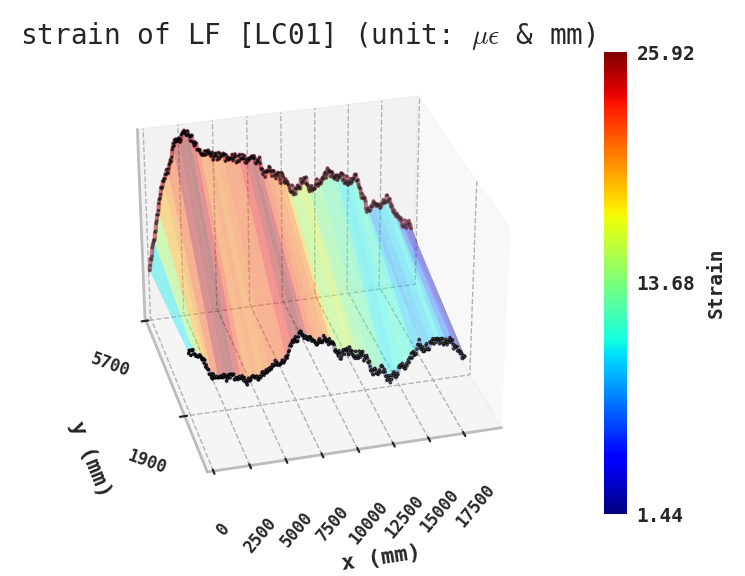

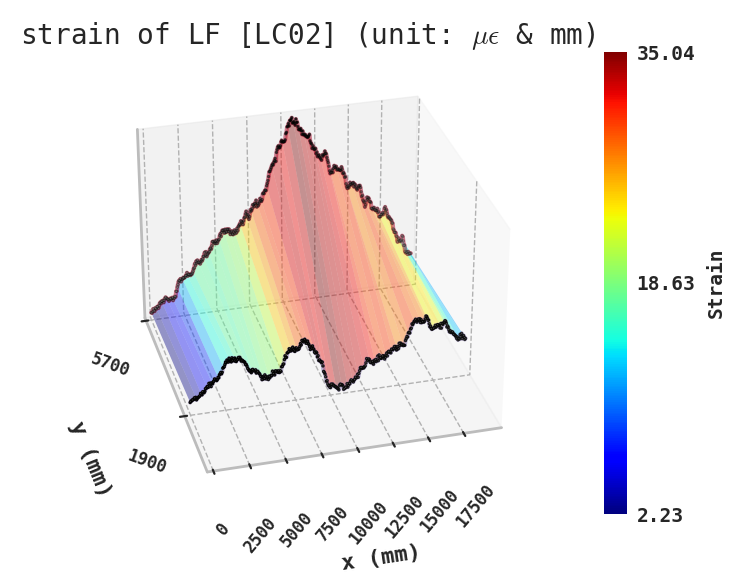

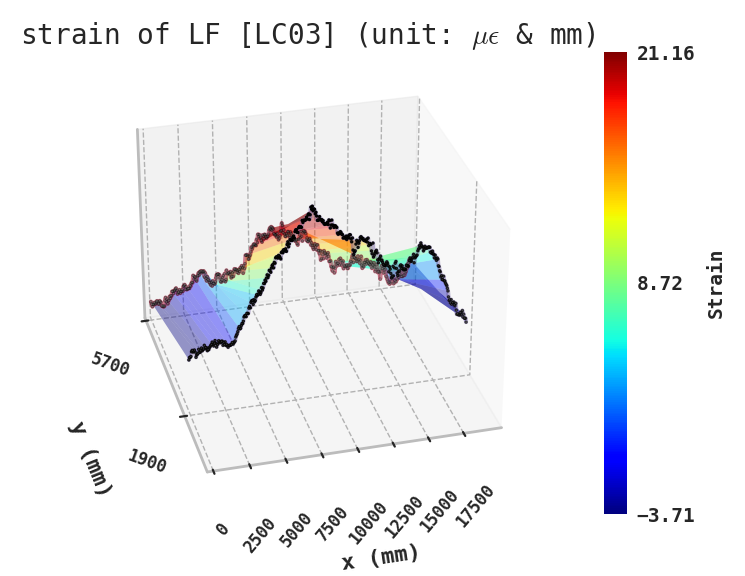

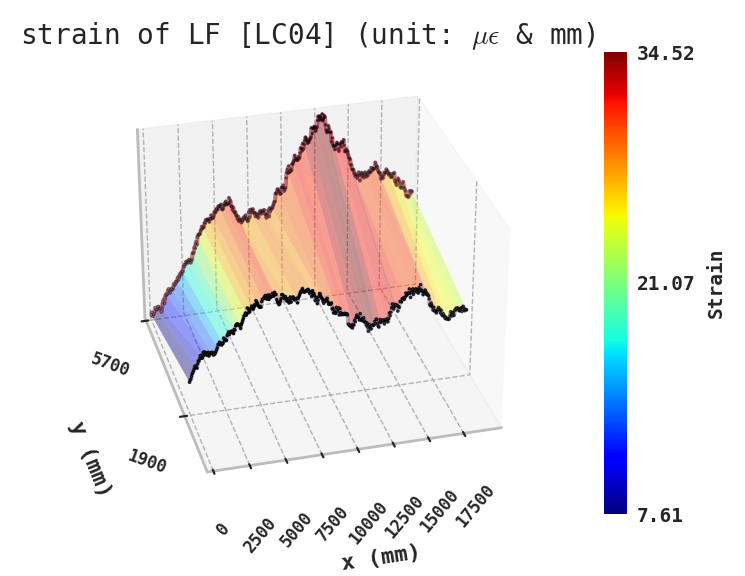

In [21]:
import matplotlib as mpl
for i_case in range(strain['LF'].shape[1] - 2):
    x_plot0 = strain['LF']['x'].unique()
    y_plot0 = strain['LF']['y'].unique()
    tmp = strain['LF'].iloc[:, i_case]

    x_plot, y_plot = np.meshgrid(x_plot0, y_plot0)
    tmp_array = strain['LF'].iloc[:, i_case].values.reshape(y_plot0.shape[0], x_plot0.shape[0])

    fig = plt.figure(figsize = (8, 3), facecolor='w', dpi = 200)
    ax1 = fig.add_subplot(111, projection ='3d', facecolor='w')
    ax1.plot_surface(x_plot, y_plot, tmp_array, alpha=0.4, cmap=cm.jet)
    
    for y_ind in y_plot0:
        ind_ = (strain['LF']['y'] == y_ind)
        ax1.plot(strain['LF']['x'].loc[ind_], strain['LF']['y'].loc[ind_], tmp[ind_],
                '-', alpha = 0.5, linewidth = 1.5)
    ax1.scatter(x_plot, y_plot, tmp_array, c = tmp_array, edgecolors = 'k', s = 0.5)
    
    ax1.set_title(f'strain of LF [LC0{i_case+1}] (unit: $\mu \epsilon$ & mm) ', pad = -50, fontsize = 10)
    ax1.set_xlabel(f'x (mm)', fontsize = 8)
    ax1.set_ylabel(f'y (mm)', fontsize = 8)
    ax1.set_xlim((0, x_plot.max()))
    ax1.set_ylim((0, tmp_array.max()))
    ax1.set_zlim((tmp_array.min(), tmp_array.max()))
    ax1.tick_params(axis='x', labelsize=6, rotation = 50)
    ax1.tick_params(axis='y', labelsize=6, rotation = -20)
    ax1.set_zticks([])
    ax1.xaxis.labelpad = 5
    ax1.yaxis.labelpad = 5
    ax1.set_yticks(y_plot0)
    # ax1.view_init(90, -90) # 2D
    ax1.view_init(30, -105)

    cmap = cm.jet ## 또는 plt.cm.get_cmap('bwr')
    # cmap = cmap.reversed() ## 색상을 반대로 적용하기
    vmax = tmp_array.max()
    vmin = tmp_array.min()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    colormapping = cm.ScalarMappable(norm=norm, cmap=cmap)
    cbar = fig.colorbar(colormapping, ax=ax1) ## 컬러바 삽입
    cbar.ax.tick_params(labelsize=7)
    cbar.set_label('Strain', fontsize = 7) ## 컬러바 라벨
    cbar.set_ticks([vmin, 0.5*(vmin+vmax), vmax]) ## 컬러바 눈금 좌표 설정    
    cbar.ax.spines['outline'].set_visible(False) ## 컬러바 테두리 제거
    cbar.ax.tick_params(size=0) ## 눈금 제거
    plt.show()

In [22]:
# Set target values
df = strain['LF']
tmp_list = []
for idx, (x_, y_) in enumerate(zip(strain['HF']['x'].values, strain['HF']['y'].values)):
        Index_label1 = df[df['x'] == x_].index.tolist()
        Index_label2 = df[df['y'] == y_].index.tolist()
        Index_final = np.intersect1d(Index_label1, Index_label2)
        
        if len(Index_final): # avoid breaking loop due to error (i.e., missing points)
            tmp = df.loc[Index_final].iloc[:, :-2].values.reshape(-1).tolist()
            tmp.extend(strain['HF'].iloc[idx, :-2].values.reshape(-1))
            tmp_list.append(tmp)

tmp_list = np.concatenate([
    np.array(tmp_list),
    strain['HF']['x'].values.reshape(-1, 1),
    strain['HF']['y'].values.reshape(-1, 1),], axis = 1)
df_test_set = pd.DataFrame(tmp_list)
df_test_set.columns = [f'LF{i}' for i in range(strain['LF'].shape[1] - 2)] + [f'HF{i}' for i in range(strain['HF'].shape[1] - 2)] + ['x', 'y']
df_test_set.to_csv('Yongsu_strain_shared.csv', index = False)

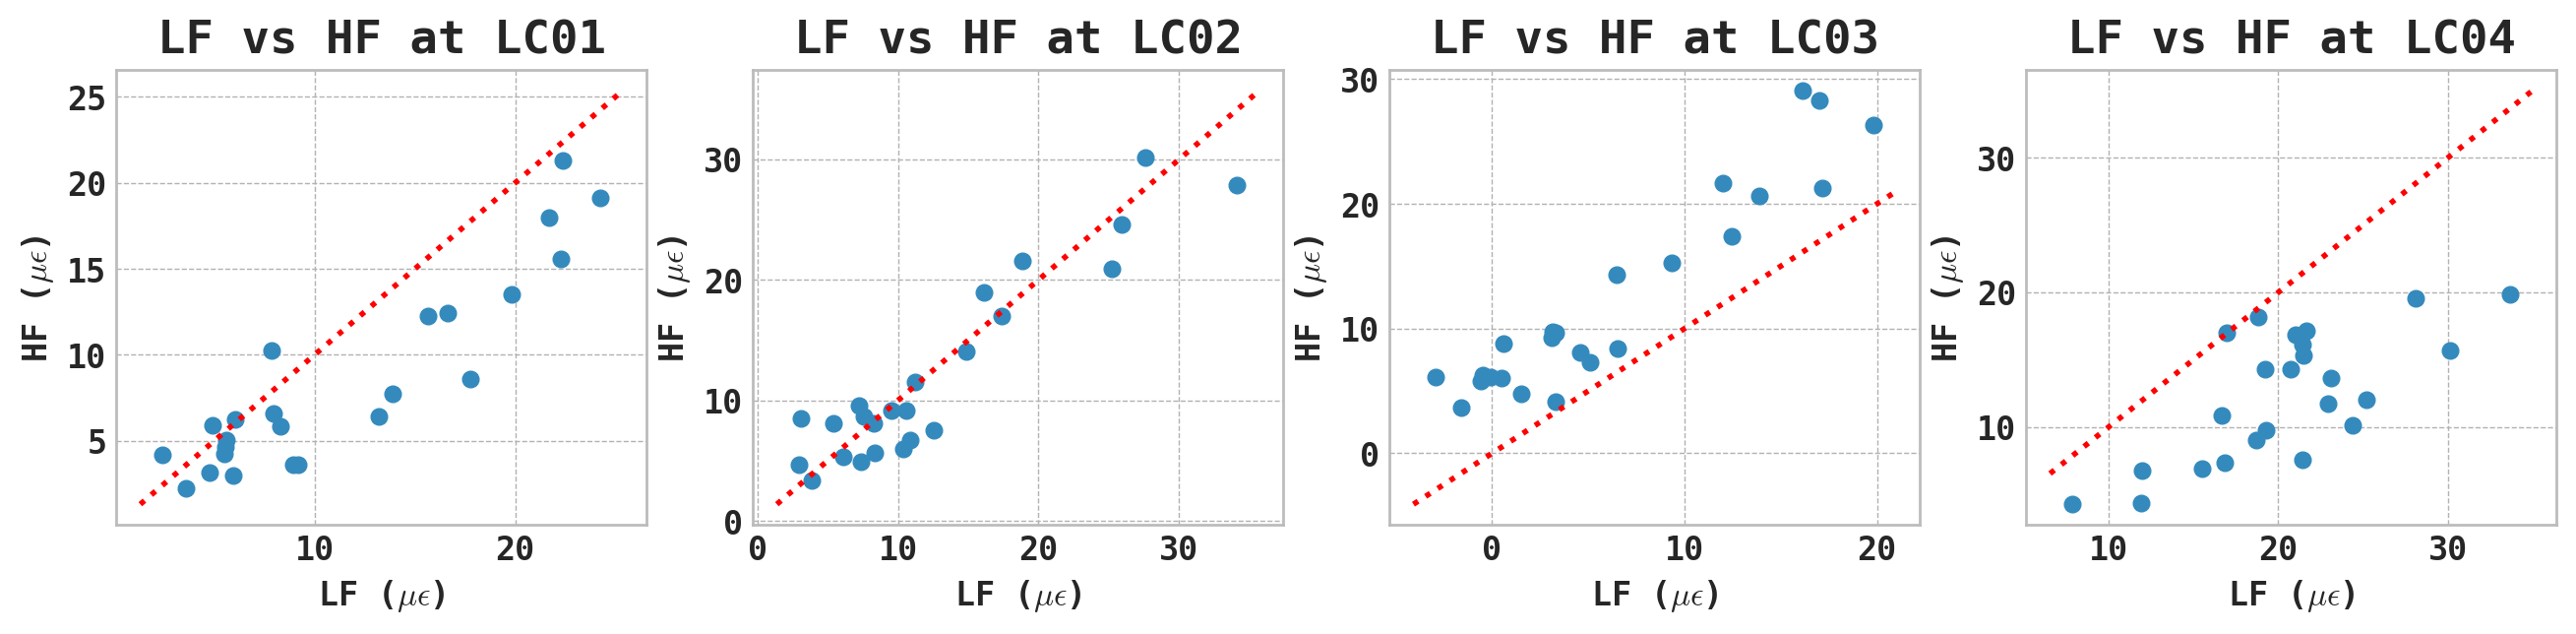

In [23]:
n_cases = len(lc_cases)-1

# Check corss-correlation
fig, axs = plt.subplots(1,n_cases, figsize = (4 * n_cases, 3), dpi = 200)

for ind in range(n_cases):
    x = df_test_set[f'LF{ind}']
    y = df_test_set[f'HF{ind}']

    axs[ind].scatter(x, y)
    axs[ind].set_xlabel('LF ($\mu \epsilon$)', fontsize = 12, weight='bold')
    axs[ind].set_ylabel('HF ($\mu \epsilon$)', fontsize = 12, weight='bold')
    axs[ind].set_title(f'LF vs HF at LC0{(ind+1)}', fontsize = 17, weight='bold')
    xmin_, xmax_ = axs[ind].get_xlim()
    axs[ind].plot([xmin_, xmax_], [xmin_, xmax_], 'r:', label = 'x = y')
plt.show()

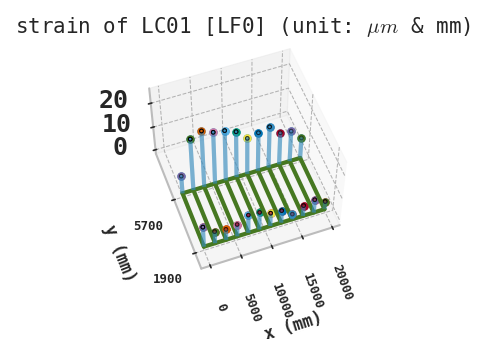

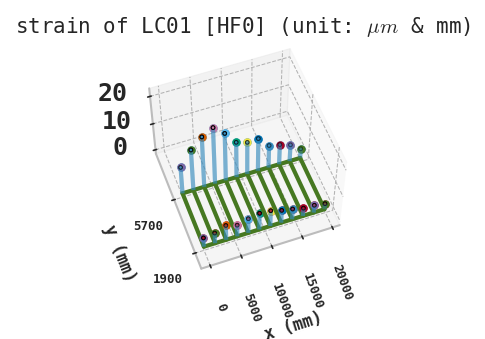

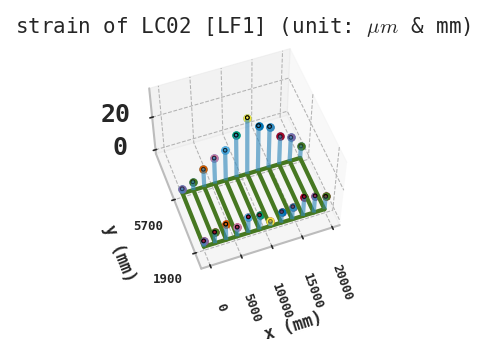

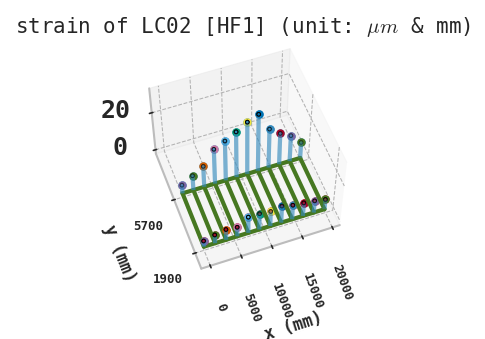

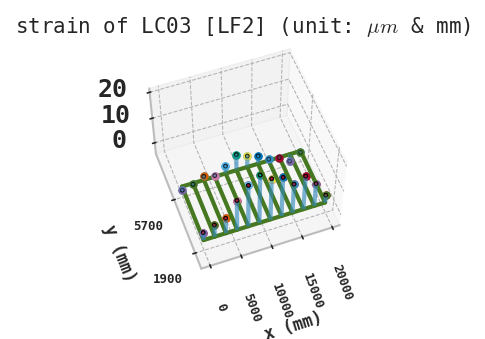

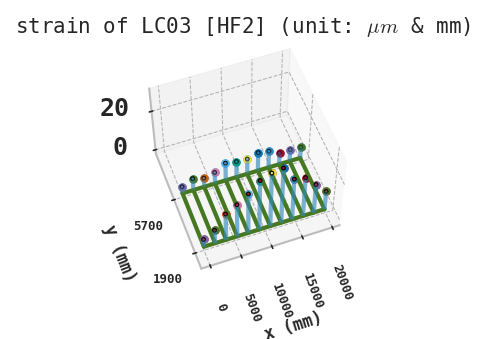

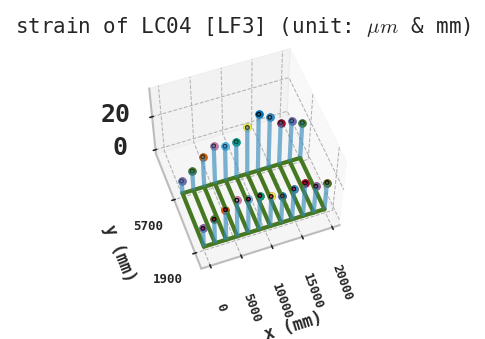

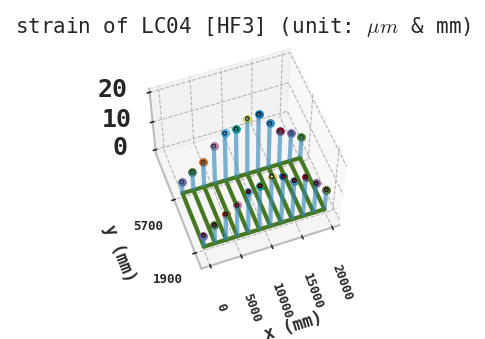

In [24]:
for ind in range(int((df_test_set.shape[1]-2)/2)):
    plot_sctter3D(df_test_set, key = f'LF{ind}', type = f'LC0{ind+1}')
    plot_sctter3D(df_test_set, key = f'HF{ind}', type = f'LC0{ind+1}')

In [25]:
strain

{'LF0':           LC01      LC02       LC03      LC04        x       y
 0     4.869000  1.011667  -2.236000  7.078333      0.0  5700.0
 1     5.697667  0.527667  -2.144000  7.506667     50.0  5700.0
 2     5.991333  1.098667  -2.635667  6.570333    100.0  5700.0
 3     7.192667  1.290000  -2.069000  6.804000    150.0  5700.0
 4     6.781000  1.178333  -1.837333  7.368667    200.0  5700.0
 ...        ...       ...        ...       ...      ...     ...
 997   2.668333  3.368000 -10.650667  4.928667  24800.0  1900.0
 998   2.787333  3.204000 -10.375333  4.894667  24850.0  1900.0
 999   1.922000  3.410667 -10.885667  4.484333  24900.0  1900.0
 1000  2.545333  3.622333 -11.868667  4.975000  24950.0  1900.0
 1001  2.499000  3.471000 -11.975333  4.861333  25000.0  1900.0
 
 [1002 rows x 6 columns],
 'HF':          LC01       LC02       LC03       LC04        x       y
 0   10.262937   4.694480   3.630255   4.270129      0.0  5700.0
 1   15.589250   8.127203   6.242445   6.777314   1800.0  570